In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import operator

import peakutils

import string
import nltk
stopwords = nltk.corpus.stopwords.words('english')

import operator
from collections import Counter
import scipy.stats

import pickle
from sklearn.feature_extraction.text import CountVectorizer

import plotly
import plotly.plotly as py
from plotly import tools

import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='sreejith_s', api_key='rcet0rTqFCc3WeOzWTjv')

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set_style('white')
import matplotlib.pylab as plt

In [4]:
filename = "/mnt/disks/vault/analysis-data/interdisciplinary-novelty-analysis/corrected-entropy-analysis/word-journey-data.pql"
data_grouped_by_year_label = pd.read_pickle(filename)

In [5]:
discipline = "Biochemistry & Molecular Biology"
input_ = data_grouped_by_year_label[data_grouped_by_year_label.Label == discipline]
data_grouped_by_year_label = None

In [6]:
vectorizer = CountVectorizer()
vectorized_words = vectorizer.fit_transform(input_.title_words)

vectorized_wordarray = vectorized_words.toarray()
document_frequency = (vectorized_wordarray != 0).sum(0).tolist()
document_frequency_log =  [np.log(x) for x in document_frequency]
#2. Term Frequency - Number of times in which a word appears in a document
term_frequency = vectorized_words.sum(axis=0).reshape(-1,).tolist()[0]
term_frequency_log = [np.log(x) for x in term_frequency]

In [7]:
vectorized_wordarray.shape

(117, 311198)

In [8]:
input_["number_of_pubs"] = input_["title_without_stopwords"].progress_apply(lambda x: len(x))
input_["word_count"] = input_["title_words"].progress_apply(lambda x: len(x.split()))

Progress: 100%|██████████| 117/117 [00:02<00:00, 51.43it/s]


In [9]:
input_.head()

,index,Label,PubYear,title_without_stopwords,cleaned_titles,title_words_,title_words,number_of_pubs,word_count
1625,1625,Biochemistry & Molecular Biology,1900,"[remarks previous essay ivar bang , remarks pr...","[remarks nucleothistone , concerning sulphur e...",remarks nucleothistone concerning sulphur exc...,remarks nucleothistone concerning sulphur excr...,178,463
1626,1626,Biochemistry & Molecular Biology,1901,"[proteolytic enzyme thymus , proteolytic enzym...",[de contamination toxins means superoxide wel...,de contamination toxins means superoxide well...,de contamination toxins means superoxide well ...,226,576
1627,1627,Biochemistry & Molecular Biology,1902,"[effect erepsin chyle toxins abrin , effect er...",[representation crystallised urinary albumose ...,representation crystallised urinary albumose ...,representation crystallised urinary albumose e...,244,628
1628,1628,Biochemistry & Molecular Biology,1903,"[lecithiane significance living cells , lecith...",[quantitative determination beta oxibutanoic a...,quantitative determination beta oxibutanoic ac...,quantitative determination beta oxibutanoic ac...,318,859
1629,1629,Biochemistry & Molecular Biology,1904,"[response vahlen , response vahlen , pharmacol...",[application reducible dyes study distribution...,application reducible dyes study distribution ...,application reducible dyes study distribution ...,312,844


In [10]:
count_matrix = vectorized_words.toarray()

uniques = []
counts = []

for i in range(count_matrix.shape[0]):
    unique_, counts_tmp = np.unique(count_matrix[i:i+1,:], return_counts=True)    
    counts_ = list(map(np.log, counts_tmp))
    uniques.append(unique_)
    counts.append(counts_)

In [11]:
yearly_word_frequency_variations = []
avg_variations_for_freq = []

for index in tqdm(range(vectorized_wordarray.shape[0] - 1)):
    
    # take two consecutive years
    tmp_ = vectorized_wordarray[index:index+2]
    
    #unique counts for the first year
    unique_counts = np.unique(tmp_[0]) 
    
    yearly_avg_variations_for_freq = {}
    word_freq_variations = []
    
    word_freq_variations.append(tmp_[1] - tmp_[0])
    
    yearly_word_frequency_variations.append(word_freq_variations)
    
    for uniq in unique_counts:
        # find the indices where the value == uniq
        indices, = np.where(tmp_[0] == uniq)
        
        # find the values in the next year where those indices are
        # variations of words with that `uniq` count
        transition_values = tmp_[1][indices]
        variations = transition_values - uniq
        
        # mean variation of words with that `uniq` count
        mean_variation = np.mean(variations)
        
        # make a list of mean variations
        yearly_avg_variations_for_freq[uniq] = round(mean_variation, 3)
    
    avg_variations_for_freq.append(yearly_avg_variations_for_freq)

100%|██████████| 116/116 [00:07<00:00,  6.76it/s]


In [12]:
len(yearly_word_frequency_variations)

116

3153 words with 3 counts
[1.35219339e-02 2.05146501e-04 7.53638291e-08 3.82095585e+18
 3.77887085e-06 1.56989123e-09 3.36151015e-11 7.33586914e-13
 3.63060862e-16 8.18821074e-18 1.62333768e-14 5.18538600e-26
 9.73987771e-23 4.24548600e-21 2.24345879e-24 1.85927102e-19
 8.33023490e-36]
0.32548837847493506 -1.1906556467476935e-28 3.7208081874404177


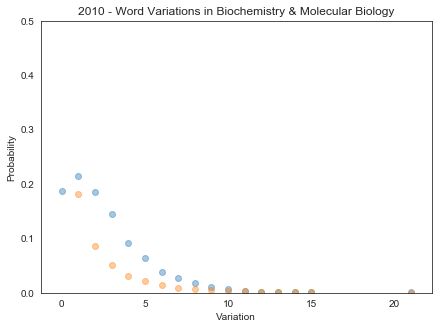

In [68]:
K = 3
f = plt.figure(figsize=(7,5))


year = 2010
N = 111
freq_current = list(vectorized_wordarray[N:N+1,:][0])
freq_next = list(vectorized_wordarray[N+1:N+2,:][0])
indices = [i for i, x in enumerate(freq_current) if x == K]
print(str(len(indices)) + " words with " + str(K) + " counts")
change_in_values = [freq_next[i] for i in indices]

#----- the subtraction part had to be removed for fitting the gamma distribution -----#

#variations = [j - K for j in change_in_values]
variations = change_in_values
sum_ = sum(dict(Counter(variations)).values())


# Observed Values
from collections import Counter
X = [x for (x,y) in dict(Counter(variations)).items()]
Y = [float(y)/sum_ for x,y in dict(Counter(variations)).items()]  
ax = f.add_subplot(111)
ax.scatter(X, Y, alpha=0.4)
ax.set_xlabel("Variation")
ax.set_ylabel("Probability")
ax.set_title(str(year) + " - Word Variations in " + discipline)



#### Trying the Gamma Fit here
shape, loc, scale = scipy.stats.gamma.fit(variations)
ax.set_ylim(0.0, 0.5)
ax.scatter(X, scipy.stats.gamma.pdf(X, a=shape, scale=scale, loc=loc), alpha=0.4)

### Problem :  
print(scipy.stats.gamma.pdf(X, a=shape, scale=1/scale, loc=loc))
print(shape, loc, scale)

## calculating the SSQ
#ssq0=((yfit0-ydata)**2).sum()


__Checking if the data came from a gamma distribution__

In [52]:
Counter(variations).items()

dict_items([(1, 676), (2, 586), (4, 290), (0, 590), (3, 456), (5, 204), (6, 123), (7, 85), (9, 36), (10, 21), (8, 57), (15, 3), (13, 4), (12, 7), (14, 2), (11, 11), (21, 2)])

5.0805857240193895 100.95195373488944 21.710935567662858


Text(0,0.5,'Probability')

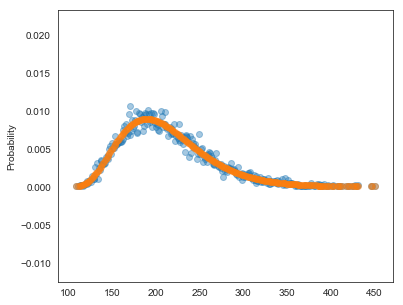

In [140]:
#  Example
# ---------
import scipy.stats as stats    
alpha = 5
loc = 100.5
beta = 22

# generate gamma data
data = stats.gamma.rvs(alpha, loc=loc, scale=beta, size=10000)    
shape, loc, scale =stats.gamma.fit(data)
print(shape, loc, scale)

from collections import Counter
counts = Counter(list(map(lambda x: round(x, 0), data))).items()

Xdata = [x for (x, y) in counts]
Y2 = [y for (x, y) in counts]
Ydata = [y/sum(Y2) for y in Y2]

f = plt.figure(figsize=(6,5))
ax = f.add_subplot(111)

ax.scatter(Xdata, Ydata, alpha=0.4)
ax.scatter(Xdata, scipy.stats.gamma.pdf(Xdata, a=shape, scale=scale, loc=loc), alpha=0.4)
ax.set_ylabel("Probability")



In [40]:
max(change_in_values)

21

In [27]:
# sum of squares for the metric
# https://stackoverflow.com/questions/23004374/how-to-calculate-the-likelihood-of-curve-fitting-in-scipy

# https://stackoverflow.com/questions/31359017/how-to-get-error-estimates-for-fit-parameters-in-scipy-stats-gamma-fit

# Fitting a poisson - https://stackoverflow.com/questions/25828184/fitting-to-poisson-histogram
